In [1]:
import matplotlib.pyplot as plt
import numpy as np
from custom_poling.core.target import Target
from custom_poling.core.custom_crystal import CustomCrystal
from Functions import Total_prop, JSA, FtS
from scipy.linalg import expm
import imageio

Since this is for Guillaume, I am just taking single pass with no poling.

In [2]:
#Parameters
Np = 0.2 # 0.000002 for low gain which agrees well ish
vp = 0.1  # pump velocity
l = 1.0  # amplification region length
sig = 1  # pump wave packet spread
a = 1.61 / 1.13  # from symmetric grp vel matching

def symmetric_v(vp, sig, l, a):
    vi = vp / (1 - 2 * a * vp / (l * sig))
    vs = vp / (1 + 2 * a * vp / (l * sig))
    return vs, vi

vs, vi = symmetric_v(vp, sig, l, a)


Ndomain = 1000
dz = (l) / Ndomain

# Crystal properties
domain_width = dz
number_domains = Ndomain
L = number_domains * domain_width
k0 = np.pi / domain_width

# Numerical integration parameters for Crystal Structure
k_range = 100/L
dk = k_range/401
k_array = np.arange(k0-k_range/2,k0+k_range/2,dk)

#For numerical FT
nk=201
k_ft = 200/L
dk = k_ft/nk
k = np.arange(-k_ft/2,k_ft/2,dk)

In [3]:
# Create a custom crystal object
custom_crystal_gauss = CustomCrystal(domain_width,number_domains)
domain_middles_gauss = custom_crystal_gauss.domain_middles

#Define and plot the target function
std = 10
height = 0.025
target_pmf_gauss = lambda k:1j*height*np.exp(-(k-k0)**2/(2*std**2))*np.exp(1j * L/2 * k)
target_gauss = Target(target_pmf_gauss,k_array)

# Compute and plot the target amplitude
target_amplitude_gauss = target_gauss.compute_amplitude(k0,domain_middles_gauss)

# Compute and plot the custom domains
custom_domains_gauss = custom_crystal_gauss.compute_domains(target_amplitude_gauss,k0)
domain = custom_domains_gauss * np.asarray([1, -1] * int(Ndomain / 2)+[1])

# defining gaussian pump pulse
def pump(x, scale=1):
    return np.exp(-((x) ** 2) / (2 * ((vp/sig)*scale) ** 2)) / np.power(np.pi * ((vp/sig)*scale)**2, 1 / 4)

#Proper scale factor
sc=std/(2*a)

In [4]:
#For a tophat potential
domain=np.asarray([1] * int(Ndomain)+[1])
sc=1

In [5]:
#Defining pump envelope and dispersion relations
Lambda =lambda x,t: np.sqrt(Np)*pump(x+l-vp*t,scale=1/sc)  #0.6*l here serves as z0, really just determined by spread
z_list = domain_middles_gauss-l/2
ws = vs*k
wi = vi*k
t=np.arange(0,20+0.05,0.05)

In [6]:
K = Total_prop(domain,Lambda,z_list,k,t,ws,wi)

In [7]:
J, Ns, Schmidt, M, Nums, Numi = JSA(K,dk)

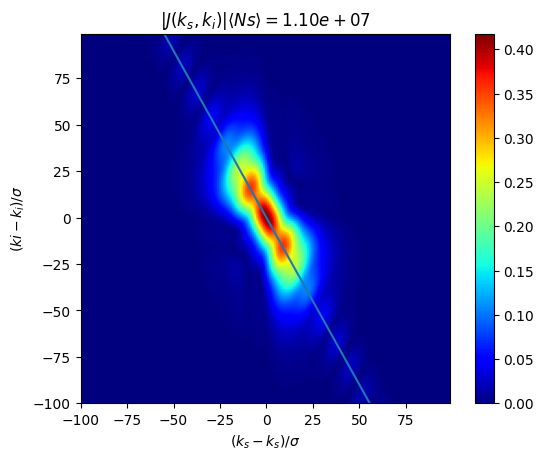

1.0060276182613161

In [8]:
fig, ax = plt.subplots()
im = ax.imshow(J, cmap="jet", origin="lower", extent=[k[0],k[nk-1],k[0],k[nk-1]])
ax.plot(-(vs/vi)*k,k)
ax.set_xlabel(r"$(k_{s}-k_{s})/\sigma$")
ax.set_ylabel(r"$(k{i}-k_{i})/\sigma$")
ax.set_title(r"$|J(k_{s}, k_{i})|    \langle Ns \rangle = %1.2e $" %Ns)
plt.colorbar(im, orientation="vertical")
plt.show()
Schmidt

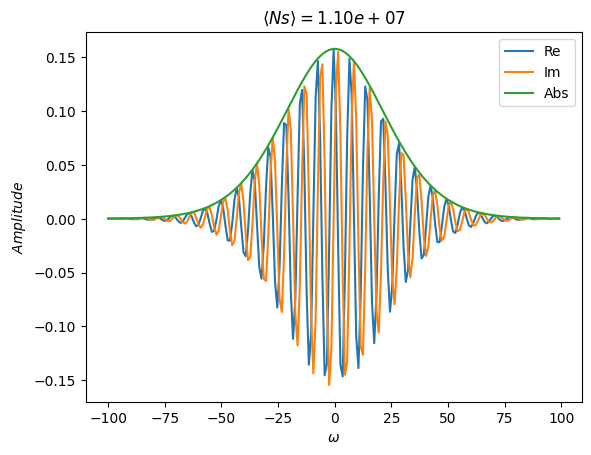

In [48]:
mark=1 #this just takes the first eigenmode of interest. Choose a different value to look at different ones.
val1, u1 = np.linalg.eigh(Nums)

fig, ax1 = plt.subplots()

ax1.plot(k, np.real(np.exp(-1j*np.angle(u1[(nk-1)//2,-mark]))*u1[:,-mark]), label='Re') #Here we multiply by a phase factor such that the imaginary part is 0 at the origin.
ax1.plot(k, np.imag(np.exp(-1j*np.angle(u1[(nk-1)//2,-mark]))*u1[:,-mark]), label='Im')
ax1.plot(k, np.abs(np.exp(-1j*np.angle(u1[(nk-1)//2,-mark]))*u1[:,-mark]), label='Abs')
ax1.set_xlabel(r"$\omega$")
ax1.set_ylabel(r"$Amplitude$")
ax1.set_title(r"$\langle Ns \rangle= %1.2e$" %Ns)
ax1.legend()
plt.show()

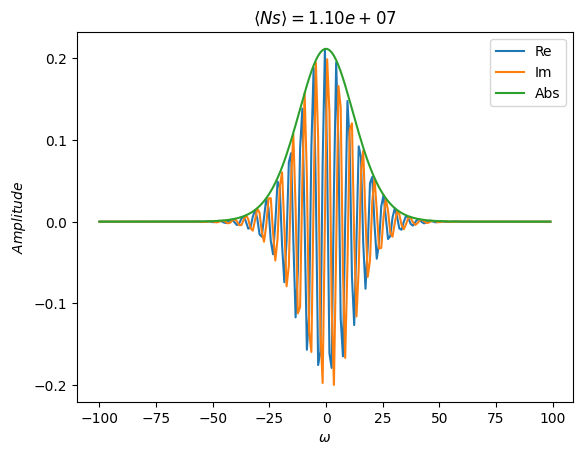

In [30]:
mark=1 #this just takes the first eigenmode of interest. Choose a different value to look at different ones.
val2, u2 = np.linalg.eigh(Numi)

fig, ax1 = plt.subplots()

ax1.plot(k, np.real(np.exp(-1j*np.angle(u2[(nk-1)//2,-mark]))*u2[:,-mark]), label='Re') #Here we multiply by a phase factor such that the imaginary part is 0 at the origin.
ax1.plot(k, np.imag(np.exp(-1j*np.angle(u2[(nk-1)//2,-mark]))*u2[:,-mark]), label='Im')
ax1.plot(k, np.abs(np.exp(-1j*np.angle(u2[(nk-1)//2,-mark]))*u2[:,-mark]), label='Abs')
ax1.set_xlabel(r"$\omega$")
ax1.set_ylabel(r"$Amplitude$")
ax1.set_title(r"$\langle Ns \rangle= %1.2e$" %Ns)
ax1.legend()
plt.show()

In [9]:
#Defining fourier transforms and spatial range
Basic_ift = lambda z,k,func: np.sum(np.exp(1j*np.tensordot(z,k,axes=0))/np.sqrt(2*np.pi)*(k[1]-k[0])*func,axis=1)
Basic_ft = lambda z,k,func: np.sum(np.exp(-1j*np.tensordot(k,z,axes=0))/np.sqrt(2*np.pi)*(z[1]-z[0])*func,axis=1) #for when you want to input a vector and not a matrix
Basic_ift2D = lambda z,k,func: np.sum(np.sum(np.exp(1j*np.tensordot(z,k-k[:,np.newaxis],axes=0))/(2*np.pi)*((k[1]-k[0])**2)*func,axis=1),axis=1) #This is to take the FT of Nums and Numi,note the sign difference for the k's

zplot=np.arange(-2,2,0.005)

In [10]:
#Energy densities <\psi(z,t)^\dagger \psi(z,t)>. Basically the 2D IFT of Nums and Numi
#These are at t[f]
NumsZ = np.real(Basic_ift2D(zplot,k,Nums))
NumiZ = np.real(Basic_ift2D(zplot,k,Numi))
Pump_E =Lambda(zplot,t[-1])*Lambda(zplot,t[-1])

#To see the evolution on the same scale, I normalize such that at t[f] the norm of the vector is 1 (not to be confused with the integral of the energy)
E_S_normed = NumsZ/Ns
E_I_normed = NumiZ/Ns
E_P_normed = Pump_E/Np

#This is to find the location of the peaks. Plotting for different gains will show if it differs.
zs=zplot[np.argmax(np.abs(NumsZ))]
zi=zplot[np.argmax(np.abs(NumiZ))]
zp=zplot[np.argmax(Pump_E)]

In [11]:
#Little sanity checks, theres discrepency in Ns due to numerical errors from FT.
np.allclose(np.sum(Pump_E)*(zplot[1]-zplot[0]),Np),np.allclose(np.sum(NumsZ)*(zplot[1]-zplot[0]),Ns),np.sum(NumsZ)*(zplot[1]-zplot[0])/Ns


(True, False, 0.995024868267007)

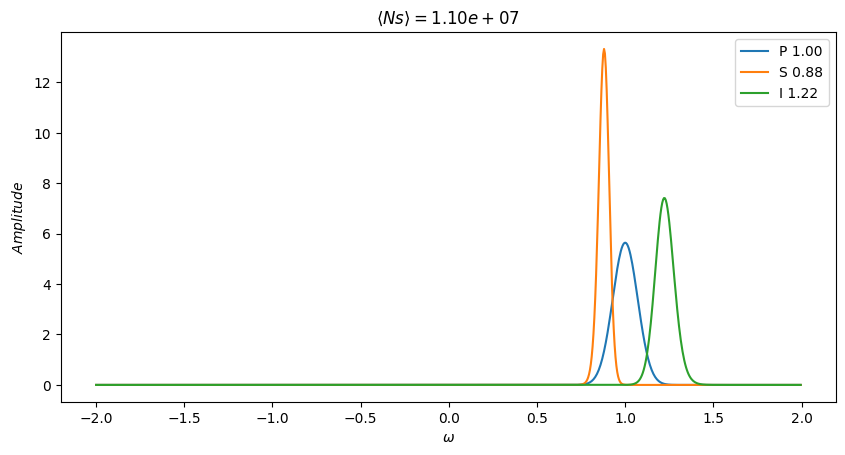

In [12]:
fig, ax1 = plt.subplots()
fig.set_figwidth(10)
ax1.plot(zplot, E_P_normed, label='P %1.2f' %zp) #Here we multiply by a phase factor such that the imaginary part is 0 at the origin.
ax1.plot(zplot, E_S_normed, label='S %1.2f' %zs)
ax1.plot(zplot, E_I_normed, label='I %1.2f' %zi)
ax1.set_xlabel(r"$\omega$")
ax1.set_ylabel(r"$Amplitude$")
ax1.set_title(r"$\langle Ns \rangle= %1.2e$" %Ns)
ax1.legend()
plt.show()

In [49]:
mark=1

In [50]:
Nsz = Basic_ift(zplot,k,np.conj(u1[:,-mark]))*np.sqrt(np.sqrt(dz)/(2*np.pi))#*(np.sqrt(np.sum(val1))
Niz = Basic_ift(zplot,k,np.conj(u2[:,-mark]))*np.sqrt(np.sqrt(dz)/(2*np.pi))#*(np.sqrt(np.sum(val2))

In [51]:
zs=zplot[np.argmax(np.abs(Nsz))]
zi=zplot[np.argmax(np.abs(Niz))]
zp=zplot[np.argmax(Lambda(zplot,t[-1]))]

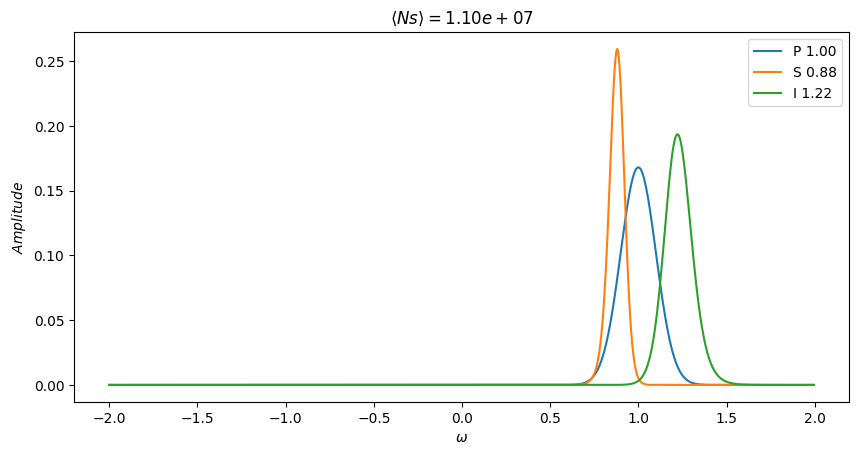

In [52]:
fig, ax1 = plt.subplots()
fig.set_figwidth(10)
ax1.plot(zplot, Lambda(zplot,t[-1])/c, label='P %1.2f' %zp) #Here we multiply by a phase factor such that the imaginary part is 0 at the origin.
ax1.plot(zplot, np.abs(Nsz), label='S %1.2f' %zs)
ax1.plot(zplot, np.abs(Niz), label='I %1.2f' %zi)
ax1.set_xlabel(r"$\omega$")
ax1.set_ylabel(r"$Amplitude$")
ax1.set_title(r"$\langle Ns \rangle= %1.2e$" %Ns)
ax1.legend()
plt.show()

In [23]:
t=np.arange(0,20+0.05,0.05)
#t=np.arange(0,2+0.5,0.5)  #to test that the next part works

DONT FORGET TO CHANGE IMAGE FILE NAME FOR SAVES

In [13]:
#Initializing
KT = np.identity(2 * len(k), dtype=np.complex128)
dk = k[1]-k[0]
dt = t[1]-t[0]

zst = np.zeros_like(t)
zit = np.zeros_like(t)
zpt = np.zeros_like(t)
    
ind = 0    
#Constructing the diagonal blocks
Rs = np.diag(-1j*ws)
Ri = np.diag(1j*wi)
    
for i in t:
    S = 1j*FtS(domain,Lambda,z_list,k,i)*dk/np.sqrt(2*np.pi)
    Q = np.block([[Rs,S],[np.conjugate(S),Ri]])
    KT = expm(Q*dt)@KT

    JT, NsT, SchmidtT, MT, NumsT, NumiT = JSA(KT,dk) #T because they are temporary
    NumsZT = np.real(Basic_ift2D(zplot,k,NumsT))
    NumiZT = np.real(Basic_ift2D(zplot,k,NumiT))
    Pump_ET =Lambda(zplot,i)*Lambda(zplot,i)

    #To see the evolution on the same scale, I normalize such that at t[f] the norm of the vector is 1 (not to be confused with the integral of the energy)
    #This is why we need to run everything before once
    E_S_normedT = NumsZT/Ns
    E_I_normedT = NumiZT/Ns
    E_P_normedT = Pump_ET/Np

    zst[ind]=zplot[np.argmax(np.abs(NumsZT))]
    zit[ind]=zplot[np.argmax(np.abs(NumiZT))]
    zpt[ind]=zplot[np.argmax(Pump_ET)]
        
    ind=ind+1

    """fig, ax1 = plt.subplots()
    fig.set_figwidth(10)
    ax1.plot(zplot, E_P_normedT, label='P' ) #Here we multiply by a phase factor such that the imaginary part is 0 at the origin.
    ax1.plot(zplot, E_S_normedT, label='S' )
    ax1.plot(zplot, E_I_normedT, label='I' )
    ax1.plot(zplot, (np.heaviside(zplot+1/2,0)-np.heaviside(zplot-1/2,0))*14, label='Crystal')
    ax1.set_xlabel(r"$z$")
    ax1.set_ylabel(r"$Amplitude$")
    ax1.set_title(r"$\langle Ns \rangle= %1.2e$" %Ns)
    ax1.set_ylim(0, 6)
    ax1.legend()
    plt.savefig(f'imgElow_{i}.png', 
                transparent = False,  
                facecolor = 'white'
               )
    plt.close()"""

DONT FORGET TO CHANGE GIF TITLE AND LOADED IMAGES

In [27]:
frames = []
for i in t:
    image = imageio.v2.imread(f'imgElow_{i}.png')
    frames.append(image)

imageio.mimsave('evolution_low.gif',frames, duration=200)   

In [14]:
#Rudimentary average velocities in two different regions

vsc = (zst[250]-zst[200])/(t[250]-t[200])
vse = (zst[-1]-zst[-41])/(t[-1]-t[-41])
vic = (zit[250]-zit[200])/(t[250]-t[200])
vie = (zit[-1]-zit[-41])/(t[-1]-t[-41])

Text(0.5, 1.0, 'Signal Position $\\langle Ns \\rangle= 1.10e+07$')

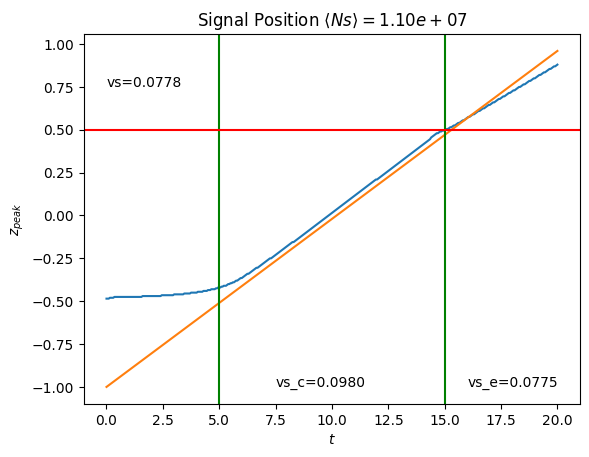

In [15]:
fig, ax1 = plt.subplots()
ax1.plot(t,zst)
ax1.plot(t,vsc*t-l)
ax1.text(0,0.75, 'vs=%1.4f' %vs)
ax1.text(7.5,-1, 'vs_c=%1.4f' %vsc)
ax1.text(16,-1, 'vs_e=%1.4f' %vse)
ax1.axvline(x=t[100],color='g')
ax1.axvline(x=t[300], color='g')
ax1.axhline(y=0.5, color='r')
ax1.set_xlabel(r"$t$")
ax1.set_ylabel(r"$z_{peak}$")
ax1.set_title(r"Signal Position $\langle Ns \rangle= %1.2e$" %Ns)

Text(0.5, 1.0, 'Idler Position $\\langle Ns \\rangle= 1.10e+07$')

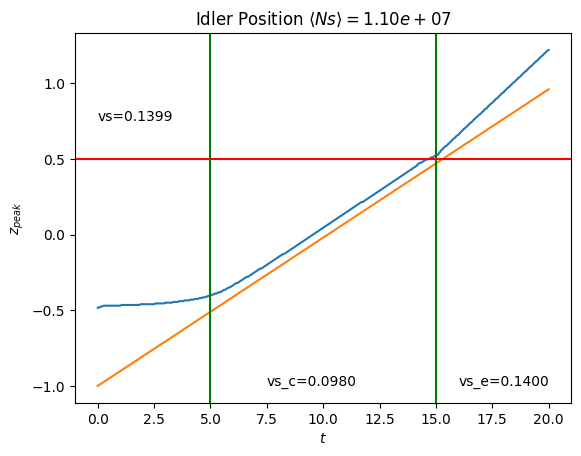

In [16]:
fig, ax1 = plt.subplots()
ax1.plot(t,zit)
ax1.plot(t,vic*t-l)
ax1.text(0,0.75, 'vs=%1.4f' %vi)
ax1.text(7.5,-1, 'vs_c=%1.4f' %vic)
ax1.text(16,-1, 'vs_e=%1.4f' %vie)
ax1.axvline(x=t[100],color='g')
ax1.axvline(x=t[300], color='g')
ax1.axhline(y=0.5, color='r')
ax1.set_xlabel(r"$t$")
ax1.set_ylabel(r"$z_{peak}$")
ax1.set_title(r"Idler Position $\langle Ns \rangle= %1.2e$" %Ns)